# **Number classification algorithm**

## **Image Traitement**

Before using the ML algorithm it must verify that the images that will be used in the classification is in the same format and size as the ones in the database (MNIST)

In [2]:
import os
import csv
import cv2 as cv
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

from keras.datasets import mnist
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import itertools
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [17]:
# This function is responsable to open all the images obtained by the camera and already processed. 
# The images are transform to be able to compare with the EMNIST database. To do so, basically,
# the function bellow identiify the number in the image, remove this number, insert it in a new image
# in the format of the database and create a file test.cvs to be use by the machine learning's algorithms. 

def image_traitement(image_path):

    # set the parameters to read the images
    image_path_chiffre = image_path # path of the file
    chiffre = image_path_chiffre[-2] # number of the dice

    # list to store all the images in the folder
    image_list = []
    for x in os.listdir(image_path_chiffre):
        path_image = image_path_chiffre + x
        im = cv.imread(path_image, 0)
        image_list.append(im)

    # list with images after the processing
    resized_list = []

    # image processing for each image of the folder
    for im in image_list:

        # convert the color to gray
        imgray = cv.cvtColor(im, cv.COLOR_GRAY2BGR) #for better accuracy, use binary images
        
        # apply the threshold to invert the pixels of the image
        # all pixels value equal to 255 (white) will be set to 0 (black)
        ret, thresh = cv.threshold(im, 225, 255, cv.THRESH_BINARY_INV) #OBS: try change to imgray
        #plt.imshow(im, cmap='gray') # image with the pixels inverted
        
        # calculate all the countors of the image
        # the variable contours contains points of the countors
        contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        
        # loop over the contours points, calculate the area of these points and 
        # chose the first area that is sufficently large
        for i in range(len(contours)):

            # calcul de la zone des contours
            area = cv.contourArea(contours[i])

            # if the contour is sufficiently large, it must be the digit
            if area > 50 and area < 700:
                
                # compute the bounding box where (x,y) is the top-left coordinate of the rectangle 
                # and (w,h) is the width and height
                (x, y, w, h) = cv.boundingRect(contours[i]) # calcul de coordonnes de la zone

                # affiche les rectangles sur l'image binaire
                #cv.rectangle(imgray, (x,y), (x+w,y+h), (255,255,0), 2) 

                # extract the region of interest (ROI) using the informations of the bounding box
                diceROI = thresh[y-2 : y+h+2, x-2 : x+w+2] # extraction de la zone sur l'image    
                #plt.matshow(diceROI, cmap="gray")
                break
                 
        # calculate the center of mass, the height and the width of the ROI
        centre_h, centre_w = ndimage.measurements.center_of_mass(diceROI)
        h, w = diceROI.shape
        
        # create a new image and insert the ROI
        n = 56 # the ROI will be insert in the center of a bigger image
        
        black_image = np.zeros((n,n))
        black_image[int((n-h)/2) : int(((n-h)/2)+h), int((n-w)/2) : int(((n-w)/2)+w)] = diceROI 
        #plt.matshow(black_image, cmap='gray')

        # resize the image to the format 28x28 pixel (format of the database)
        scale_percent = 50 # percent of original size
        
        width = int(black_image.shape[1] * scale_percent / 100)
        height = int(black_image.shape[0] * scale_percent / 100)
        dim = (width, height)

        # resize the image
        resized = cv.resize(black_image, dim, interpolation = cv.INTER_AREA)
        resized_list.append(resized) # add to the list of final images

        # write the pixel matrix in the test.csv file, the row will have 785 columns (28x28 + 1)
        # where the last column is the dice's number
        A = np.asarray(resized).reshape(-1) # shape the matrix to just one line
        
        row = []
        for result in A:
            row.append(result)
        row.append(float(chiffre)) #the last column is the dice's number

        # open the file in the for appending new information (new row)
        with open('test.csv', "a") as file:
            writer = csv.writer(file)
            writer.writerow(row) 

    # print the processed images 
    #print("Dice's number: " + str(chiffre))
    #print("Number of the images in the folder: " + str(len(image_list)))
    #print("Number of the images created: " + str(len(resized_list)))
    #for pos in range(0, len(resized_list)):
    #    plt.matshow(resized_list[pos], cmap='gray')
    '''
    if os.path.isfile('test.csv'):
        print ("END")
    else:
        print ('file does not exist')
    '''

# Read database

Functions used to read the database (train and test) from MNIST and also from the csv file generated with the images captured from the pico camera

In [3]:
import create_database as cdb

In [3]:
class Digit:
    def __init__(self, data, target):
        self.target = target
        self.width  = int(np.sqrt(len(data)))
        self.image  = data.reshape(self.width, self.width)
        self.features = {'var' : 0,
                         'std' : 0,
                         'mean_grad_M' : 0,
                         'std_grad_M'  : 0,
                         'mean_grad_D' : 0,
                         'std_grad_D'  : 0,
                         'mean_PC_X'   : 0,
                         'std_PC_X'    : 0,
                         'active_PC_X' : 0,
                         'mean_PC_Y'   : 0,
                         'std_PC_Y'    : 0,
                         'active_PC_Y' : 0}
        self.computeFeatures()
    
    def computeFeatures(self):
        # Feature computation
        mag, ang = sobel(self.image)
        pcx, pcy = pixel_count(self.image)
        
        self.features['var'] = np.var(self.image)
        self.features['std'] = np.std(self.image)
        self.features['mean_grad_M'] = np.mean(mag)
        self.features['std_grad_M'] =  np.std(mag)
        self.features['mean_grad_D'] = np.mean(ang)
        self.features['std_grad_D'] =  np.std(ang)
        self.features['mean_PC_X'] =   np.mean(pcx)
        self.features['std_PC_X'] =    np.std(pcx)
        self.features['active_PC_X'] = np.count_nonzero(pcx)
        self.features['mean_PC_Y'] =   np.mean(pcy)
        self.features['std_PC_Y'] =    np.std(pcy)
        self.features['active_PC_Y'] = np.count_nonzero(pcy) 
  
    def __print__(self):
        print("Digit target: "+str(self.target))
        print("Digit features:")
        print(self.features)
        print("Digit image:")
        plt.gray()
        plt.matshow(self.image) 
        plt.show()

In [4]:
def sobel(image):
    w = len(image)
    kernel_x = np.array([ [ 1, 0,-1],
                          [ 2, 0,-2],
                          [ 1, 0,-1] ])

    kernel_y = np.array([ [ 1, 2, 1],
                          [ 0, 0, 0],
                          [-1,-2,-1] ])
    
    grad_x = np.zeros([w - 2, w - 2])
    grad_y = np.zeros([w - 2, w - 2])
    
    for i in range(w - 2):
        for j in range(w - 2):
            grad_x[i, j] = sum(sum(image[i : i + 3, j : j + 3] * kernel_x))
            grad_y[i, j] = sum(sum(image[i : i + 3, j : j + 3] * kernel_y))
            if grad_x[i, j] == 0:
                grad_x[i, j] = 0.000001
    
    mag = np.sqrt(grad_y * 2 + grad_x * 2)
    ang = np.arctan(grad_y / (grad_x + np.finfo(float).eps))
  
    # Gradient computation
  
    return [mag,ang]

def pixel_count(image):
    pc_x = np.zeros(len(image))
    pc_y = np.zeros(len(image))
  
    # Pixel count computation
    for i in range(len(image)):
        pc_x[i] = np.count_nonzero(image[i, :])
        pc_y[i] = np.count_nonzero(image[:, i])

    return [pc_x, pc_y]

In [5]:
class Dataset:
    def __init__(self, filename, length):  
        self.filename = filename
        if length == -1:
            with open(self.filename, 'r') as csvfile:
                spamreader = csv.reader(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_NONNUMERIC) 
                self.length = sum(1 for row in spamreader)
        else: 
            self.length = length
            self.digits = []
        self.digits = self.createDigits()
        self.raw_features = [[float(f) for f in dig.features.values()] for dig in self.digits]
        self.raw_targets  = [[self.digits[i].target] for i in range(self.length)]
  
    def createDigits(self):
        # Parse the csv file row by row and create Digits on the fly
        digits = []
        with open(self.filename, 'r') as csvfile:
            spamreader = csv.reader(csvfile, delimiter = ',', quotechar = '|', quoting = csv.QUOTE_NONNUMERIC)
            for i, row in enumerate(spamreader):
                if i == self.length: break
                digits.append(Digit(np.array(row[:-1]), row[-1]))
                
        return digits

In [6]:
# n1 : percent of the number of lines in the data base use as training set
# n2 : percent of the number of lines in the data base use as testing set
def load_data_sets(n1, n2):
    
    print("Creating training set")
    with open(os.getcwd() + "/training_database.csv") as f:
        lines = sum(1 for line in f)
        print("Number of the lines in the database: " + str(lines)) 

    print("Number of the lines in the training set: "+ str(int(n1*lines)))
    training_set = Dataset(os.getcwd() + "/training_database.csv",int(n1*lines))

    print("\nCreating testing set")
    with open(os.getcwd() + "/testing_database.csv") as f:
        lines = sum(1 for line in f)
        print("Number of the lines in the database: " + str(lines))

    print ("Number of the lines in the database: " + str(int(n2*lines)))
    testing_set = Dataset(os.getcwd() + "/testing_database.csv", int(n2*lines))

    print ("\nFinished creating datasets")
    
    return training_set, testing_set

In [8]:
%%time
training_set, testing_set = load_data_sets(1, 1)

Creating training set
Number of the lines in the database: 482
Number of the lines in the training set: 482


/home/morooka/.local/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt



Creating testing set
Number of the lines in the database: 482
Number of the lines in the database: 482

Finished creating datasets
CPU times: user 10.5 s, sys: 28.1 ms, total: 10.5 s
Wall time: 10.5 s


In [9]:
def cvt_obj_nparray(dataset):
    X = np.zeros((dataset.length, 12))
    Y = np.zeros((dataset.length,))
    for i, digit in enumerate(dataset.digits):
        Y[i] = digit.target
        for j, feature in enumerate(digit.features):
            X[i, j] = digit.features[feature]
    return X, Y

X_train, Y_train = cvt_obj_nparray(training_set)
X_test, Y_test = cvt_obj_nparray(testing_set)

In [10]:
from sklearn.tree import DecisionTreeClassifier
# Decision Tree initialization
clf = DecisionTreeClassifier(random_state = 0, max_depth = 100)

print("Training classifier")
# Training Decision Tree
clf.fit(Xtrain, Ytrain)

acc_train = clf.score(Xtrain, Ytrain)
print("Score on training set: {}".format(acc_train))
# Compute prediction accuracy on training set

acc_test = clf.score(Xtest, Ytest)
print("Score on testing set: {}".format(acc_test))
# Compute prediction accuracy on testing set

acc_new_test = clf.score(Xtrain2, Ytrain2)
print("Score on new testing set: {}".format(acc_new_test))
# Compute prediction accuracy on new testing set

Training classifier


NameError: name 'Xtrain' is not defined

In [18]:
#Extract the numbers from database

def selectDiceNumbers(img_list_all, labels_list_all):
    img_final = []
    labels_final = []
    diceNumbers = [1, 2, 3, 4, 5, 6]

    if len(img_list_all) == len(labels_list_all):
        initialSize = range(len(img_list_all))
    else:
        print("Size of lists must be the same!")

    for i in initialSize:
        if (labels_list_all[i] in diceNumbers):
            img_final.append(img_list_all[i])
            labels_final.append(labels_list_all[i])
    
    return img_final, labels_final

def load_datasets():
    print("Loading Training dataset and Testing dataset...")
    (img_train_all, labels_train_all),(img_test_all, labels_test_all) = mnist.load_data()
    
    img_train, labels_train = selectDiceNumbers(img_train_all, labels_train_all)
    img_test, labels_test = selectDiceNumbers(img_test_all, labels_test_all)

    print("Finished loading!")
    
    return img_train, labels_train, img_test, labels_test
    
X_train, Y_train, X_test, Y_test = load_datasets()
#Train dataset size = 36012
#Test dataset size = 6009

Loading Training dataset and Testing dataset...
Finished loading!


In [19]:
def create_number_list(data):
    images = []
    for x in data:
        images.append(x.reshape(-1))

    return images

In [20]:
def read_test():    
    image = []
    labels = []
    with open('test.csv', 'r') as csvfile:
        spamreader = csv.reader(csvfile, delimiter = ',', quotechar = '|', quoting = csv.QUOTE_NONNUMERIC)
        for line in spamreader:
            image.append(np.array(line[:-1]))
            labels.append(line[-1])
    
    return image, labels

# **Evaluation methods**

This part contains the functions used to analyse the accuracy of the classifier

In [21]:
def plot_confusion_matrix(clf, data_x, data_y):
    classes = ['1', '2', '3', '4', '5', '6']

    Ypred = clf.predict(data_x)
    
    # Computation of confusion matrix on testing set
    cm = confusion_matrix(data_y, Ypred)
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# **KK Neighborhod algorithm**

In [22]:
def train_knnModel(N, i):
    # Train on the first N train images
    train_x = create_number_list(X_train[:N])
    train_y = np.array(Y_train[:N])
    
    #Train the classifier
    clf = KNeighborsClassifier(n_neighbors=i)
    print("Finished trainning KNN Model with " + str(i) + " neighbors")
    return clf.fit(train_x, train_y)

knn_classificator = train_knnModel(1000, 5)

Finished trainning KNN Model with 5 neighbors


In [18]:
def train_knnModel(N, i):
    # Train on the first N train images
    train_x = X_train[:N]
    train_y = Y_train[:N]
    
    #Train the classifier
    clf = KNeighborsClassifier(n_neighbors=i)
    print("Finished trainning KNN Model with " + str(i) + " neighbors")
    return clf.fit(train_x, train_y)

knn_classificator = train_knnModel(100, 5)

Finished trainning KNN Model with 5 neighbors


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

The accuracy for MNIST test database is: 89.759%
Using: 1000 images


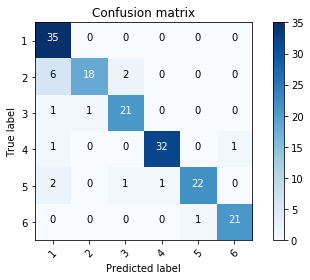

In [23]:
def test_knnModel(N):
    # Test on the next N/6 test images:
    test_x = create_number_list(X_test[:N/6])
    test_y = np.array(Y_test[:N/6]) 
    predicted = knn_classificator.predict(test_x)
    print("The accuracy for MNIST test database is: " + str(round((accuracy_score(test_y, predicted) * 100), 3)) + "%")

    print("Using: " + str(N) + " images")
    
    plot_confusion_matrix(knn_classificator, test_x, test_y)
    plt.show()

test_knnModel(1000)

The accuracy for photos taken is: 52.632%
Using: 38 images


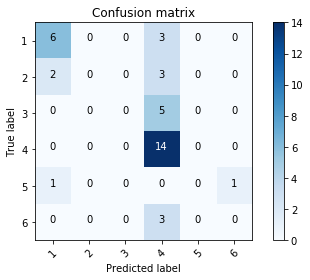

In [24]:
def test_photos_knnModel():
    #New set of values
    test_x_photos, test_y_photos = read_test()
    predicted_photos = knn_classificator.predict(test_x_photos)
    
    print("The accuracy for photos taken is: " + str(round((accuracy_score(test_y_photos, predicted_photos) * 100), 3)) + "%")
    print("Using: " + str(len(test_y_photos)) + " images")
    
    plot_confusion_matrix(knn_classificator, test_x_photos, test_y_photos)
    plt.show()
    
test_photos_knnModel()

# **Multiple Hyperparameter Study**
This part consist in making a study of the hyperparameter of the classifier, using the gridsearch method from the scikitlearn library.

In [25]:
from sklearn.grid_search import RandomizedSearchCV
from sklearn.grid_search import GridSearchCV

In [26]:
# Define the parameter values that should be searched
k_range = list(range(1, 31))

# Another parameter besides k that we might vary is the weights parameters or even the algorithm
weight_options = ['uniform', 'distance']
algorithm_options = ['auto', 'ball_tree', 'kd_tree', 'brute']

# Specify "parameter grid"
param_grid = dict(n_neighbors=k_range, weights=weight_options, algorithm=algorithm_options)

# Specify "parameter distributions" rather than a "parameter grid"
param_dist = dict(n_neighbors=k_range, weights=weight_options, algorithm=algorithm_options)

# Since both parameters are discrete, so param_dist is the same as param_grid

# Finally define the classifier, in this case the KNN classifier
knn = KNeighborsClassifier()

In [28]:
%%time

# This block is done both grid and random search for the hyperparameters for N numbers
N = 100

grid_best_scores = []
grid_best_params = []
grid_best_estimator = []

rand_best_scores = []
rand_best_params = []
rand_best_estimator = []

train_x = create_number_list(X_train[:N])
train_y = np.array(Y_train[:N])

for _ in list(range(20)):
    grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', n_jobs = -1)
    grid.fit(train_x, train_y)
    grid_best_scores.append(grid.best_score_)
    grid_best_params.append(grid.best_params_)
    grid_best_estimator.append(grid.best_estimator_)

    rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring='accuracy', n_iter=10, n_jobs = -1)
    rand.fit(train_x, train_y)
    rand_best_scores.append(rand.best_score_)
    rand_best_params.append(rand.best_params_)
    rand_best_estimator.append(rand.best_estimator_)
    
print("Finished searching the hyper parameters!")


Finished searching the hyper parameters!
CPU times: user 1min 40s, sys: 16.2 s, total: 1min 56s
Wall time: 1min 52s


In [32]:
rand_best_estimator[np.argmax(rand_best_scores)]

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

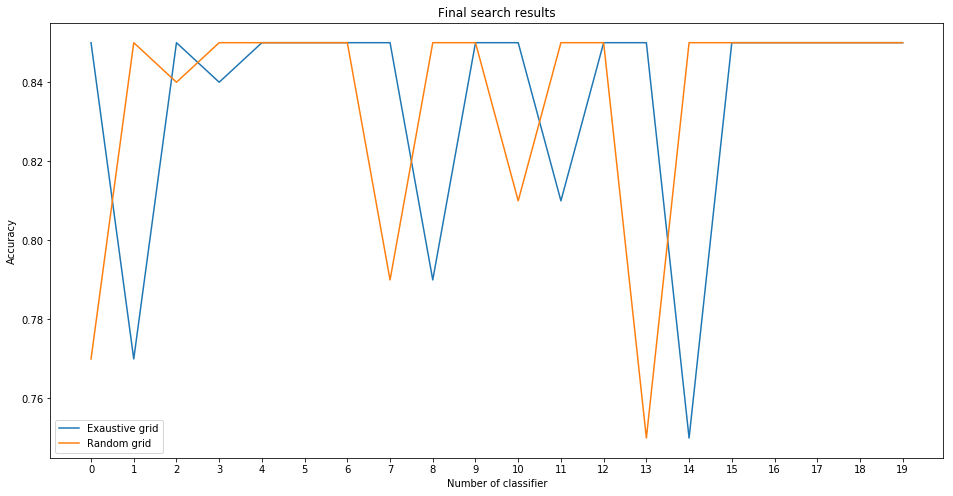

GRID SEARCH RESULTS
The best accuracy is: 85.0%
The parameters is: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'brute'}


RANDOMGRID SEARCH RESULTS
The best accuracy is: 85.0%
The parameters is: {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'brute'}


In [43]:
# This block draw accuracies of the differents classifiers used in the grid and random search

plt.figure(figsize=(16, 8))
plt.title("Final search results")   
plt.plot(range(len(grid_best_scores)), grid_best_scores, label = 'Exaustive grid')
plt.plot(range(len(rand_best_scores)), rand_best_scores, label = 'Random grid')
plt.xlabel('Number of classifier')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(range(len(grid_best_scores)))
plt.show()

print("GRID SEARCH RESULTS")
print("The best accuracy is: " + str(np.max(grid_best_scores) * 100) + "%")
print("The parameters is: " + str(grid_best_params[np.argmax(grid_best_scores)]))
print('\n')
print("RANDOMGRID SEARCH RESULTS")
print("The best accuracy is: " + str(np.max(rand_best_scores) * 100) + "%")
print("The parameters is: " + str(rand_best_params[np.argmax(rand_best_scores)]))

# Best KNN classificator

In [44]:
#Train the best classificator for a N sample of numbers
def train_best_classifier(N):
    train_x = create_number_list(X_train[:N])
    train_y = np.array(Y_train[:N])
    
    classificator = rand_best_estimator[np.argmax(rand_best_scores)]

    return classificator.fit(train_x, train_y)

In [45]:
#Testing this new classificator accuracy with MNIST database 
def test_database(clf, N):
    test_x = create_number_list(X_test[:N/6])
    test_y = np.array(Y_test[:N/6]) 

    predicted = clf.predict(test_x)
    
    print("The accuracy for MNIST test database is: " + str(round((accuracy_score(test_y, predicted) * 100), 3)) + "%")
    print("Using: " + str(N) + " images to train")
    print("Using: " + str(N/6) + " images in the test")

    plot_confusion_matrix(clf, test_x, test_y)



In [46]:
#Testing this new classificator accuracy with the photos taken
def new_test_photos(clf, N):
    test_x_photos, test_y_photos = read_test()

    predicted_photos = clf.predict(test_x_photos)
    print("The accuracy for photos taken is: " + str(round((accuracy_score(test_y_photos, predicted_photos) * 100), 3)) + "%")

    print("Using: " + str(N) + " images to train")
    print("Using: " + str(len(test_x_photos)) + " photos taken")

    plot_confusion_matrix(clf, test_x_photos, test_y_photos)



In [47]:
best_knn_classificator = train_best_classifier(200)

The accuracy for MNIST test database is: 72.727%
Using: 200 images to train
Using: 33 images in the test


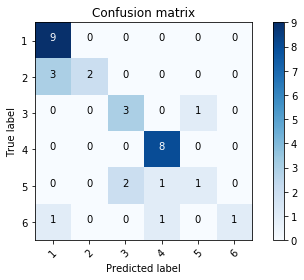

In [48]:
test_database(best_knn_classificator, 200)

The accuracy for photos taken is: 55.263%
Using: 200 images to train
Using: 38 photos taken


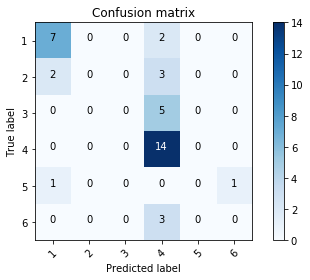

In [49]:
new_test_photos(best_knn_classificator, 200)